In [1]:
import pyedflib
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import butter, lfilter
import tensorflow as tf
from helperFunctions import *
from tensorflow.python.framework import ops
ops.reset_default_graph()
%matplotlib notebook

In [2]:
def removeConsecutives(vals, step=1):
    """Return list of consecutive lists of numbers from vals (number list)."""
    result = []
    expect = None
    for v in vals:
        if (v != expect) or (expect is None):
            result.append(v)
        expect = v + step
    return result
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a
   
   
def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y


/home/peter323/neuro3/helperFunctions.py:72: ComplexWarning: Casting complex values to real discards the imaginary part
  samples[k] = getFreqSpec(signal[k*256:k*256 + 2*256])[:int(nSignal/10)]


Step #75
Loss = 141.22
Step #150
Loss = -366.953
Step #225
Loss = -359.759
Step #300
Loss = 923.197


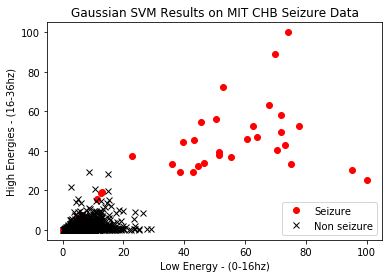

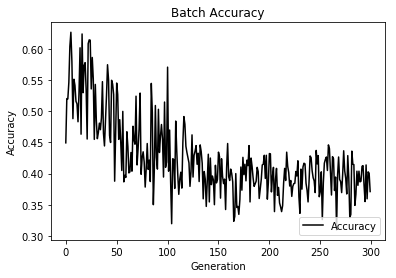

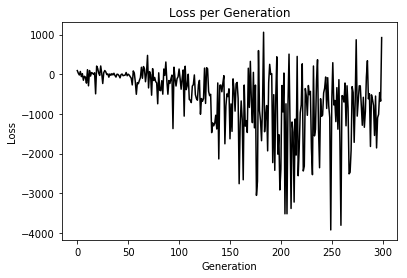

Point [ 0.  5.] is predicted to be in class 1.0
Point [ 25.   5.] is predicted to be in class -1.0
Point [ 50.   5.] is predicted to be in class 1.0
Point [ 75.   5.] is predicted to be in class 1.0
Point [  0.  40.] is predicted to be in class 1.0
Point [ 25.  40.] is predicted to be in class 1.0
Point [ 50.  40.] is predicted to be in class 1.0
Point [ 75.  40.] is predicted to be in class 1.0
Point [  0.  80.] is predicted to be in class 1.0
Point [ 25.  80.] is predicted to be in class 1.0
Point [ 50.  80.] is predicted to be in class 1.0
Point [ 75.  80.] is predicted to be in class 1.0


In [27]:

seizureList = np.loadtxt('mit_data/RECORDS-WITH-SEIZURES', dtype='str')

filenames = seizureList

#get signal
filename = 'chb05_22.edf'
signal = getSignals(filename)
fs = 256
#Apply bandpass filters to signal (currently 2)
signals = [butter_bandpass_filter(signal,0.5, 16., fs, order=5), butter_bandpass_filter(signal, 14., 36., fs, order=5)]
#Get the freqency and energys of each 2 second cut of the signal
x_valsLow, y_valsLow, lowEnergies = getFreqVals(signals[0], getSeizureTimes(filename))
x_valsHigh, y_valsHigh, highEnergies = getFreqVals(signals[1], getSeizureTimes(filename))

#Find the max of the low and high energies in order to scale the classes between 0 and 1
lowMax = lowEnergies[0].max()
highMax = highEnergies[0].max()

#combine energies into an array
y_vals = np.array(y_valsLow[0])
x_vals = np.zeros((len(y_valsLow[0]), 2))
for i in range(len(y_valsLow[0])):
    x_vals[i] = [(lowEnergies[0][i]/lowMax) * 100, (highEnergies[0][i]/highMax) * 100]

#put together classes x and y values (see Figure 6)
#Class 1 = seizure
class1_x = [(lowEnergies[0][j]/lowMax) * 100 for j in range(x_valsLow.shape[1]) if y_valsLow[0][j]==1]
class1_y = [(highEnergies[0][j]/highMax) * 100 for j in range(x_valsLow.shape[1]) if y_valsLow[0][j]==1]
class2_x = [(lowEnergies[0][j]/lowMax) * 100 for j in range(x_valsLow.shape[1]) if y_valsLow[0][j]==-1]
class2_y = [(highEnergies[0][j]/highMax) * 100 for j in range(x_valsLow.shape[1]) if y_valsLow[0][j]==-1]
#plt.plot(getFreqVec(), x_valsHigh[0][0])

#Plot both classes: Red = seizure
#plt.plot(class1_x, class1_y, 'ro')
#plt.plot(class2_x, class2_y, 'kx')

#Start svm model with one channel
guassian(x_vals, y_vals)

#classShape = np.array(x_vals.shape)
#classShape[2] = len(getFreqSpec(x_vals[0][0][seizureTimes[0][1]*256:seizureTimes[0][1]*256 + 2*256]))

In [26]:
#non-linear svm using guassian kernel
def guassian(x_vals, y_vals):
    #Start tensorflow
    sess = tf.Session()
    
    #constants
    batch_size = len(y_vals)
    gamma = tf.constant(-30.0)
    
    #placeholders
    x_data = tf.placeholder(shape=[None, 2], dtype=tf.float32)
    y_target = tf.placeholder(shape=[None, 1], dtype=tf.float32)
    prediction_grid = tf.placeholder(shape=[None, 2], dtype=tf.float32)
    
    #svm variables
    b = tf.Variable(tf.random_normal(shape=[1, batch_size]))
    
    #guassian kernel --> K(x) = exp(-gamma(x * x^T))
    sq_vec = tf.multiply(2., tf.matmul(x_data, tf.transpose(x_data)))
    my_kernel = tf.exp(tf.multiply(gamma, tf.abs(sq_vec)))
    
    #Compute svm model
    first_term = tf.reduce_sum(b)
    b_vec_cross = tf.matmul(tf.transpose(b), b)
    y_target_cross = tf.matmul(y_target, tf.transpose(y_target))
    second_term = tf.reduce_sum(tf.multiply(my_kernel, tf.multiply(b_vec_cross, y_target_cross)))
    loss = tf.negative(tf.subtract(first_term, second_term))
    
    #Guassian prediction
    rA = tf.reshape(tf.reduce_sum(tf.square(x_data), 1),[-1,1])
    rB = tf.reshape(tf.reduce_sum(tf.square(prediction_grid), 1),[-1,1])
    pred_sq_dist = tf.add(tf.subtract(rA, tf.multiply(2., tf.matmul(x_data, tf.transpose(prediction_grid)))), tf.transpose(rB))
    pred_kernel = tf.exp(tf.multiply(gamma, tf.abs(pred_sq_dist)))

    prediction_output = tf.matmul(tf.multiply(tf.transpose(y_target),b), pred_kernel)
    prediction = tf.sign(prediction_output-tf.reduce_mean(prediction_output))
    accuracy = tf.reduce_mean(tf.cast(tf.equal(tf.squeeze(prediction), tf.squeeze(y_target)), tf.float32))
    
    #Gradient Decent Optimizer
    my_opt = tf.train.GradientDescentOptimizer(0.01)
    train_step = my_opt.minimize(loss)
    
    #Initialize variables
    init = tf.global_variables_initializer()
    sess.run(init)
    
    # Training loop
    loss_vec = []
    batch_accuracy = []
    for i in range(300):
        rand_index = np.random.choice(len(x_vals), size=batch_size)
        rand_x = x_vals[rand_index]
        rand_y = np.transpose([y_vals[rand_index]])
        sess.run(train_step, feed_dict={x_data: rand_x, y_target: rand_y})

        temp_loss = sess.run(loss, feed_dict={x_data: rand_x, y_target: rand_y})
        loss_vec.append(temp_loss)

        acc_temp = sess.run(accuracy, feed_dict={x_data: rand_x,
                                                 y_target: rand_y,
                                                 prediction_grid:rand_x})
        batch_accuracy.append(acc_temp)

        if (i+1)%75==0:
            print('Step #' + str(i+1))
            print('Loss = ' + str(temp_loss))
    
    # Create a mesh to plot points in
    """x_min, x_max = x_vals[:, 0].min() - 1, x_vals[:, 0].max() + 1
    y_min, y_max = x_vals[:, 1].min() - 1, x_vals[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                         np.arange(y_min, y_max, 0.02))
    grid_points = np.c_[xx.ravel(), yy.ravel()]
    [grid_predictions] = sess.run(prediction, feed_dict={x_data: rand_x,
                                                       y_target: rand_y,
                                                       prediction_grid: grid_points})
    grid_predictions = grid_predictions.reshape(xx.shape)"""
    
    %matplotlib inline
    # Plot points and grid
    #plt.contourf(xx, yy, grid_predictions, cmap=plt.cm.Paired, alpha=0.8)
    plt.plot(class1_x, class1_y, 'ro', label='Seizure')
    plt.plot(class2_x, class2_y, 'kx', label='Non seizure')
    plt.title('Gaussian SVM Results on MIT CHB Seizure Data')
    plt.xlabel('Low Energy - (0-16hz)')
    plt.ylabel('High Energies - (16-36hz)')
    plt.legend(loc='lower right')
    plt.ylim([-5.0, 105.0])
    plt.xlim([-5.0, 105.0])
    plt.show()

    # Plot batch accuracy
    plt.plot(batch_accuracy, 'k-', label='Accuracy')
    plt.title('Batch Accuracy')
    plt.xlabel('Generation')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')
    plt.show()

    # Plot loss over time
    plt.plot(loss_vec, 'k-')
    plt.title('Loss per Generation')
    plt.xlabel('Generation')
    plt.ylabel('Loss')
    plt.show()
    
    #Test points
    x_test_seq = np.array([0., 25., 50., 75.])
    y_test_seq = np.array([5., 40., 80.])

    x_test, y_test = np.meshgrid(x_test_seq,y_test_seq)
    test_points = np.c_[x_test.ravel(), y_test.ravel()]
    
    [test_predictions] = sess.run(prediction, feed_dict={x_data: rand_x,
                                                     y_target: rand_y,
                                                     prediction_grid: test_points})
    test_predictions = test_predictions.reshape(x_test.shape)
    test_predictions.ravel()
    
    for ix, point in enumerate(test_points):
        point_pred = test_predictions.ravel()[ix]
        print('Point {} is predicted to be in class {}'.format(point, point_pred))